# MFCC feature extraction and GMM-based music genre classification pipeline.

This notebook implements a music genre classification system based on statistical audio features and **Gaussian Mixture Models (GMMs)**.

The workflow includes audio preprocessing, feature extraction, model training, and evaluation on a held-out test set. Two alternative datasets are supported: a default instructor-provided dataset and the GTZAN dataset, allowing comparative experimentation.

The notebook is designed to be configurable, enabling the user to select the dataset, model parameters, and evaluation settings. Detailed analysis and discussion of the methodology and results are provided in the accompanying report.


## Imports and Runtime Configuration

In [1]:
import librosa
import soundfile
import scipy
import sklearn
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import kagglehub
import random
import shutil

# Disable warnings for a cleaner output
import warnings
warnings.filterwarnings("ignore")

## OPTIONS
Here you can customize various options.

In [7]:
# Dataset Parameters
RUN_DATASETS = ["default", "gtzan"]

DATASETS_FETCH = True # Specifies whether to download and prepare the datasets needed

GTZAN_TRAIN_RATIO = 0.8

# Options
Ks = [2, 8, 16, 64] # List of number of GMM components to try

WIN_MS = 20 # Duration (in milliseconds) of each analysis window
STEP_MS = 5 # Step size (in milliseconds) between consecutive windows

TRAIN = False # Specifies whether to train the GMM Models
BUILD_FEATURES = False # Specifies whether to build features from audio files

## Data fetch & preparation

In [3]:
if DATASETS_FETCH:  
    # Download default dataset
    path = kagglehub.dataset_download(
        "dkleidonaris/ece443-default-dataset"
    )
    
    print("Downloaded to:", path)
    
    SOURCE = Path(path)
    TARGET = Path("data-default")
    TARGET.mkdir(exist_ok=True)
    
    children = list(SOURCE.iterdir())
    
    if len(children) == 1 and children[0].is_dir():
        SOURCE = children[0]
        
    shutil.copytree(SOURCE, TARGET, dirs_exist_ok=True)

    # Download GTZAN Dataset
    path = kagglehub.dataset_download(
        "andradaolteanu/gtzan-dataset-music-genre-classification"
    )
    print("Downloaded to:", path)

    dataset_path = Path(path)
    SOURCE_ROOT = dataset_path / "Data" / "genres_original"

    GENRES = sorted([p.name for p in SOURCE_ROOT.iterdir() if p.is_dir()])

    songs_by_genre = {
        genre: list((SOURCE_ROOT / genre).glob("*.wav"))
        for genre in GENRES
    }

    train_songs = {}
    test_songs = {}

    random.seed(42)

    for genre, songs in songs_by_genre.items():
        random.shuffle(songs)
        split = int(len(songs) * GTZAN_TRAIN_RATIO)
        train_songs[genre] = songs[:split]
        test_songs[genre] = songs[split:]

    SPLIT_DIR = Path("data-gtzan")

    for split in ["train", "test"]:
        for genre in GENRES:
            (SPLIT_DIR / split / genre).mkdir(parents=True, exist_ok=True)

    for genre in GENRES:
        for f in train_songs[genre]:
            shutil.copy2(f, SPLIT_DIR / "train" / genre / f.name)

        for f in test_songs[genre]:
            shutil.copy2(f, SPLIT_DIR / "test" / genre / f.name)
    
DATASETS = {
    "default": {"root": Path("data-default")},
    "gtzan":   {"root": Path("data-gtzan")}   # ✅ σωστό folder
}

def configure_dataset(dataset_name):
    cfg = DATASETS[dataset_name]
    DATA_DIR = cfg["root"]

    TRAIN_DIR = DATA_DIR / "train"
    GENRES = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])

    FEAT_DIR = DATA_DIR / "features"
    MODEL_DIR = DATA_DIR / "models"
    RESULTS_DIR = Path("results") / dataset_name

    FEAT_DIR.mkdir(parents=True, exist_ok=True)
    MODEL_DIR.mkdir(parents=True, exist_ok=True)
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    return DATA_DIR, FEAT_DIR, MODEL_DIR, RESULTS_DIR, GENRES

Downloaded to: C:\Users\DimitrisKleidonaris\.cache\kagglehub\datasets\dkleidonaris\ece443-default-dataset\versions\1
Downloaded to: C:\Users\DimitrisKleidonaris\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


In [4]:
# TARGET_SR: Target sampling rate for all audio files.
# All signals are resampled to the same rate to ensure
# consistency across the dataset and comparable MFCC features.
TARGET_SR = 22050

# N_MFCC: Number of Mel-Frequency Cepstral Coefficients.
# A typical value (e.g. 13) that captures the spectral envelope
# while keeping feature dimensionality low.
N_MFCC = 13

def list_audio_files(folder: Path):
    """
    Recursively collects all .wav audio files from a given folder.
    """
    files = []
    files += list(folder.rglob("*.wav"))
    return sorted(files)

def extract_mfcc(path: Path) -> np.ndarray:
    """
    Extracts MFCC features from an audio file.

    The audio signal is resampled, segmented into overlapping
    frames, and converted into MFCC vectors.
    """
    try:
        # Load audio, convert to mono, and resample to target sampling rate
        y, sr = librosa.load(
            str(path),          # 🔴 CRITICAL FIX
            sr=TARGET_SR,
            mono=True,
            duration=30.0       # prevents hanging
        )
        
    # Skip files that cannot be loaded
    except Exception as e:
        print(f"Skipping {path.name}: {e}")
        return np.empty((0, N_MFCC), dtype=np.float32)

    if y.size == 0:
        return np.empty((0, N_MFCC), dtype=np.float32)

    # Convert window and step size from milliseconds to samples
    win_length = int((WIN_MS / 1000) * sr)
    hop_length = int((STEP_MS / 1000) * sr)

    # Choose n_fft as the smallest power of two >= window length
    # for efficient FFT computation
    n_fft = 1
    while n_fft < win_length:
        n_fft *= 2

    # Compute MFCCs; transpose so each row corresponds to one frame
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
    ).T

    return mfcc.astype(np.float32)

def build_features(DATA_DIR, FEAT_DIR, GENRES):
    """
    Extracts and stores MFCC features for all audio files
    in the dataset, organized by split and genre.
    """
    for split in ["train", "test"]:
        for genre in GENRES:
            in_dir = DATA_DIR / split / genre
            out_dir = FEAT_DIR / split / genre
            out_dir.mkdir(parents=True, exist_ok=True)

            files = list_audio_files(in_dir)
            if not files:
                print(f"⚠️ No audio files in {in_dir}")
                continue

            # Iterate over all audio files in the current genre
            for f in tqdm(files, desc=f"MFCC {split}/{genre}", unit="file"):
                mfcc = extract_mfcc(f)

                # Save MFCC features and metadata in compressed format
                np.savez_compressed(
                    out_dir / f"{f.stem}.npz",
                    mfcc=mfcc,
                    label=genre,
                    source=str(f)
                )

def load_genre_train_frames(genre: str, FEAT_DIR: Path) -> np.ndarray:
    files = sorted((FEAT_DIR / "train" / genre).glob("*.npz"))
    if not files:
        raise RuntimeError(f"No training features found for genre '{genre}' in {FEAT_DIR}")

    frames = []
    for f in files:
        data = np.load(f)
        frames.append(data["mfcc"])

    return np.vstack(frames)

def train_gmm_system(K, FEAT_DIR, MODEL_DIR, GENRES):
    """
    Trains one Gaussian Mixture Model (GMM) per genre
    using K Gaussian components.
    """
    # Load all training frames (for scaling)
    all_frames = np.vstack([load_genre_train_frames(g, FEAT_DIR) for g in GENRES])

    # Fit a global scaler to normalize MFCC features
    scaler = StandardScaler().fit(all_frames)
    joblib.dump(scaler, MODEL_DIR / "scaler.joblib")

    models = {}

    # Train one GMM per genre
    for genre in tqdm(GENRES, desc=f"Training GMMs (K={K})"):
        X = load_genre_train_frames(genre, FEAT_DIR)
        
        # Apply feature normalization before GMM training
        X = scaler.transform(X)

        gmm = GaussianMixture(
            n_components=K,
            covariance_type="diag",
            max_iter=200,
            reg_covar=1e-6,
            random_state=0
        )

        gmm.fit(X)

        models[genre] = gmm
        
        # Save trained GMM model to disk
        joblib.dump(gmm, MODEL_DIR / f"gmm_{genre}_K{K}.joblib")

    return models

In [10]:
def load_models(K, MODEL_DIR, GENRES):
    scaler = joblib.load(MODEL_DIR / "scaler.joblib")
    gmms = {g: joblib.load(MODEL_DIR / f"gmm_{g}_K{K}.joblib") for g in GENRES}
    return scaler, gmms

def classify_track(feature_file, scaler, gmms):
     # Load MFCC features from the stored .npz file
    data = np.load(feature_file)

    # Normalize features using the trained scaler
    X = scaler.transform(data["mfcc"])

    # Compute average log-likelihood per frame for each genre GMM
    scores = {g: gmms[g].score(X) for g in GENRES}

    # Select the genre with the highest likelihood score
    predicted = max(scores, key=scores.get)
    
    return predicted, scores

def evaluate_system(K, FEAT_DIR, MODEL_DIR, GENRES):
    # Load scaler and trained GMMs for the given number of components
    scaler, gmms = load_models(K, MODEL_DIR, GENRES)

    # Lists to store ground-truth and predicted labels
    y_true, y_pred = [], []

    # Iterate over each true genre
    for true_genre in GENRES:
        # Collect all test feature files for the current genre
        test_files = (FEAT_DIR / "test" / true_genre).glob("*.npz")

        # Classify each test track and store results
        for f in tqdm(test_files, desc=f"Evaluating K={K}, true={true_genre}"):
            pred, _ = classify_track(f, scaler, gmms)
            y_true.append(true_genre)
            y_pred.append(pred)

    # Compute overall classification accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Compute confusion matrix with fixed label ordering
    cm = confusion_matrix(y_true, y_pred, labels=GENRES)
    
    per_genre_acc = {}
    for i, g in enumerate(GENRES):
        denom = cm[i].sum()
        per_genre_acc[g] = (cm[i, i] / denom) if denom > 0 else 0.0
    
    return acc, cm, per_genre_acc

def save_accuracy_table(dataset_results, results_dir):
    """
    dataset_results[K] = {"accuracy": float, "per_genre": {genre:acc,...}, ...}
    Saves:
      - accuracy_overall.csv (K vs accuracy)
      - accuracy_per_genre.csv (K vs per-genre acc)
    Returns (df_overall, df_genre)
    """
    overall_rows = []
    genre_rows = []

    for K, r in dataset_results.items():
        overall_rows.append({"K": K, "Accuracy": r["accuracy"]})
        row = {"K": K}
        row.update(r["per_genre"])
        genre_rows.append(row)

    df_overall = pd.DataFrame(overall_rows).sort_values("K")
    df_genre = pd.DataFrame(genre_rows).sort_values("K")

    df_overall.to_csv(results_dir / "accuracy_overall.csv", index=False)
    df_genre.to_csv(results_dir / "accuracy_per_genre.csv", index=False)

    display(df_overall)
    return df_overall, df_genre

def plot_and_save_confusion_matrix(cm, labels, title, save_path=None, dpi=200):
    """
    Shows and (optionally) saves a confusion matrix with counts printed in each cell.
    """
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_yticklabels(labels, fontsize=11)

    ax.set_xlabel("Predicted label", fontsize=12)
    ax.set_ylabel("True label", fontsize=12)
    ax.set_title(title, fontsize=13, pad=10)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, int(cm[i, j]),
                ha="center", va="center",
                fontsize=14, fontweight="bold",
                color="white" if cm[i, j] > thresh else "black"
            )

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=10)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", dpi=dpi)

    plt.show()
    plt.close(fig)

def plot_accuracy_vs_K(df_overall, title, save_path=None, dpi=200):
    plt.figure(figsize=(6, 4))
    plt.plot(df_overall["K"], df_overall["Accuracy"], marker="o")
    plt.xlabel("K (GMM components)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)
    plt.show()
    plt.close()

def plot_accuracy_bars(df_overall, title, save_path=None, dpi=200):
    plt.figure(figsize=(6, 4))
    plt.bar(df_overall["K"].astype(str), df_overall["Accuracy"])
    plt.xlabel("K (GMM components)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)
    plt.show()
    plt.close()

def plot_grouped_per_genre_accuracy(dataset_results, GENRES, Ks, title, save_path=None, dpi=200):
    """
    Grouped bars per genre: for each genre, show one bar per K using per-genre accuracy.
    dataset_results[K]["per_genre"] must exist as dict {genre: acc}.
    """
    rows = []
    for K in Ks:
        if K not in dataset_results:
            continue
        row = {"K": K}
        row.update(dataset_results[K]["per_genre"])
        rows.append(row)

    df = pd.DataFrame(rows).set_index("K").reindex(Ks)
    df = df[GENRES]  # enforce genre order

    n_genres = len(GENRES)
    n_K = len([k for k in Ks if k in df.index])

    x = np.arange(n_genres)

    # width adapts to number of K values
    width = min(0.8 / max(n_K, 1), 0.25)

    plt.figure(figsize=(max(10, n_genres * 0.9), 6))

    plotted = 0
    for i, K in enumerate(Ks):
        if K not in df.index or df.loc[K].isna().all():
            continue
        offset = (plotted - (n_K - 1) / 2) * width
        plt.bar(x + offset, df.loc[K].values, width, label=f"K={K}")
        plotted += 1

    plt.xticks(x, GENRES, rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True, axis="y")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)

    plt.show()
    plt.close()


===== DATASET: default =====

--- K = 2 ---


Evaluating K=2, true=blues: 1it [00:00, 114.92it/s]
Evaluating K=2, true=classical: 1it [00:00, 117.34it/s]
Evaluating K=2, true=reggae: 1it [00:00, 105.19it/s]


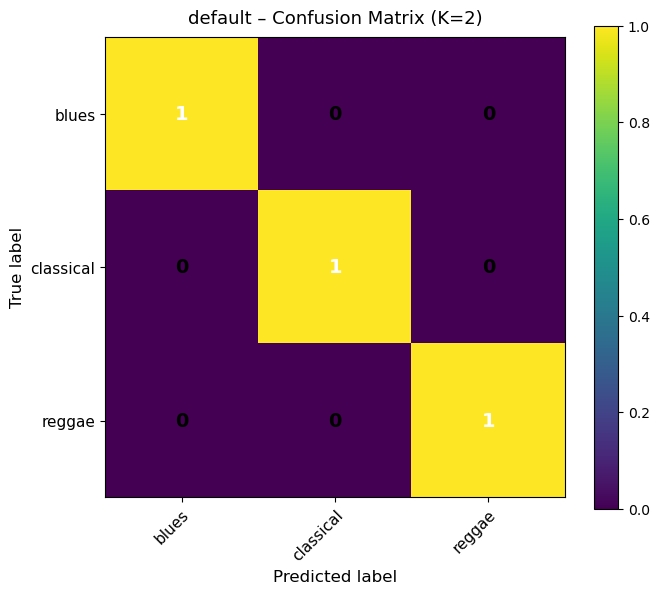


--- K = 8 ---


Evaluating K=8, true=blues: 1it [00:00, 76.54it/s]
Evaluating K=8, true=classical: 1it [00:00, 110.84it/s]
Evaluating K=8, true=reggae: 1it [00:00, 99.14it/s]


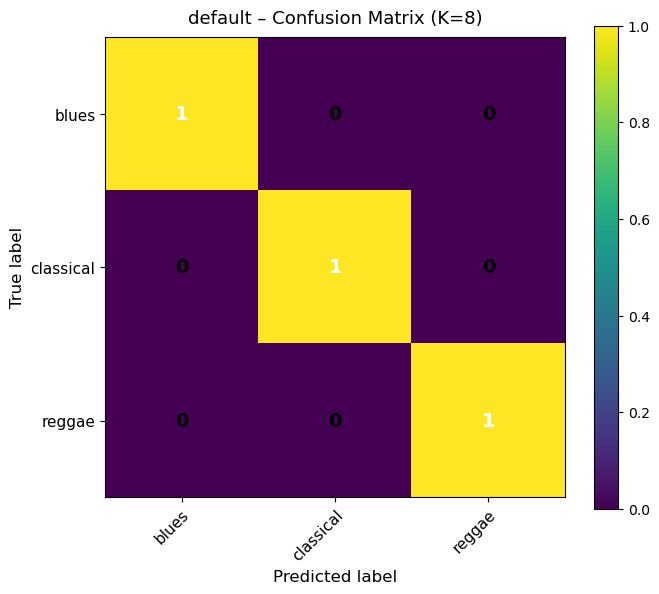


--- K = 16 ---


Evaluating K=16, true=blues: 1it [00:00, 76.65it/s]
Evaluating K=16, true=classical: 1it [00:00, 94.85it/s]
Evaluating K=16, true=reggae: 1it [00:00, 70.95it/s]


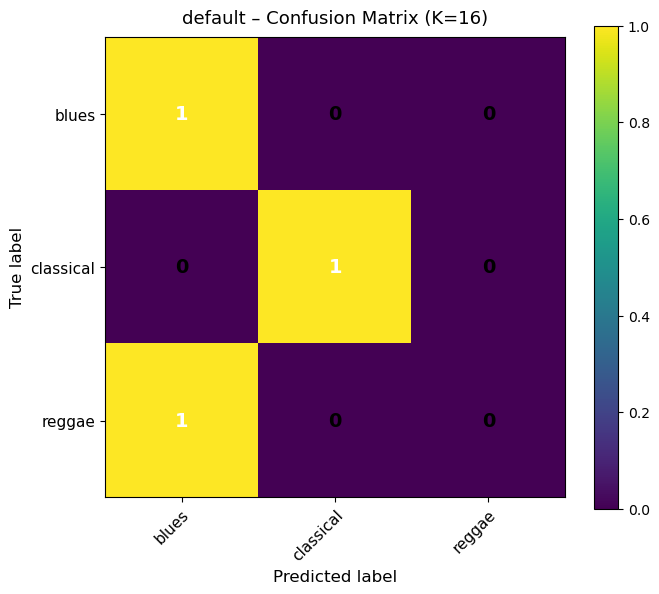


--- K = 64 ---


Evaluating K=64, true=blues: 1it [00:00, 16.81it/s]
Evaluating K=64, true=classical: 1it [00:00, 19.65it/s]
Evaluating K=64, true=reggae: 1it [00:00, 17.17it/s]


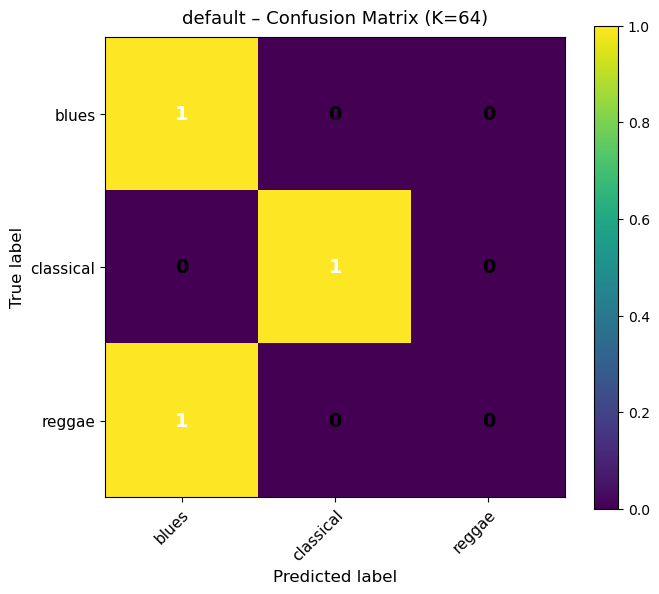

,K,Accuracy
0,2,1.000000
1,8,1.000000
2,16,0.666667
3,64,0.666667


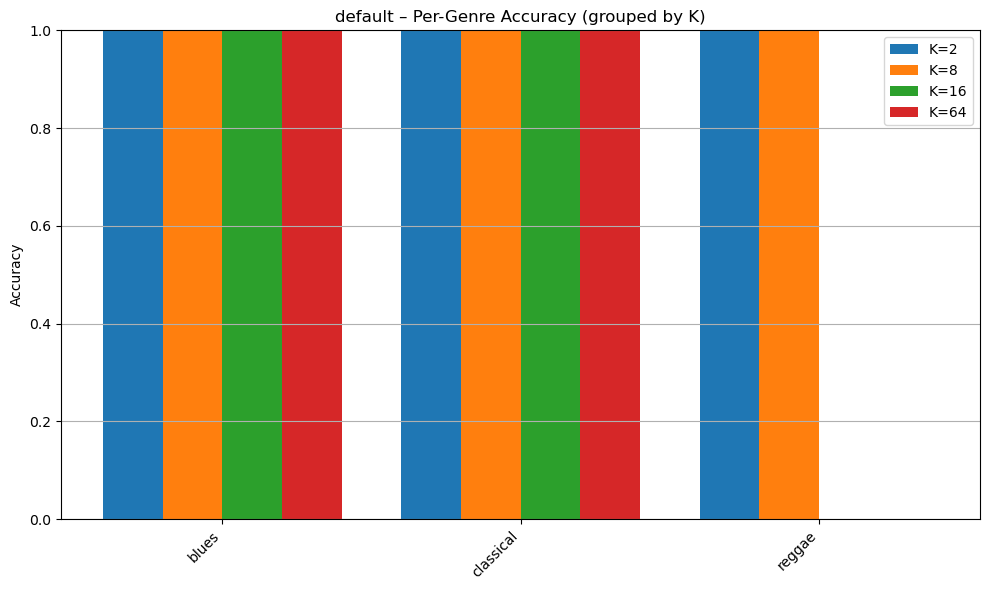

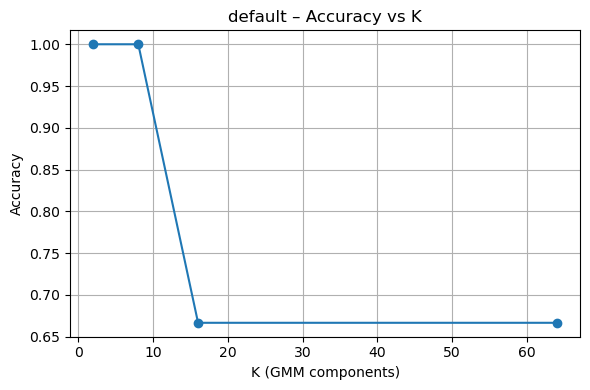

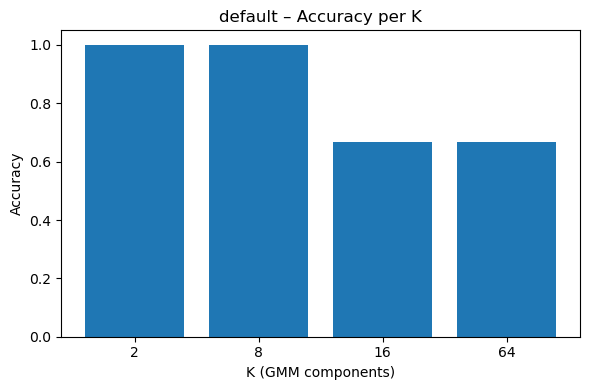


===== DATASET: gtzan =====

--- K = 2 ---


Evaluating K=2, true=blues: 20it [00:00, 56.12it/s]
Evaluating K=2, true=classical: 20it [00:00, 59.49it/s]
Evaluating K=2, true=country: 20it [00:00, 58.82it/s]
Evaluating K=2, true=disco: 20it [00:00, 57.01it/s]
Evaluating K=2, true=hiphop: 20it [00:00, 55.52it/s]
Evaluating K=2, true=jazz: 20it [00:00, 60.11it/s]
Evaluating K=2, true=metal: 20it [00:00, 56.82it/s]
Evaluating K=2, true=pop: 20it [00:00, 56.34it/s]
Evaluating K=2, true=reggae: 20it [00:00, 58.29it/s]
Evaluating K=2, true=rock: 20it [00:00, 58.59it/s]


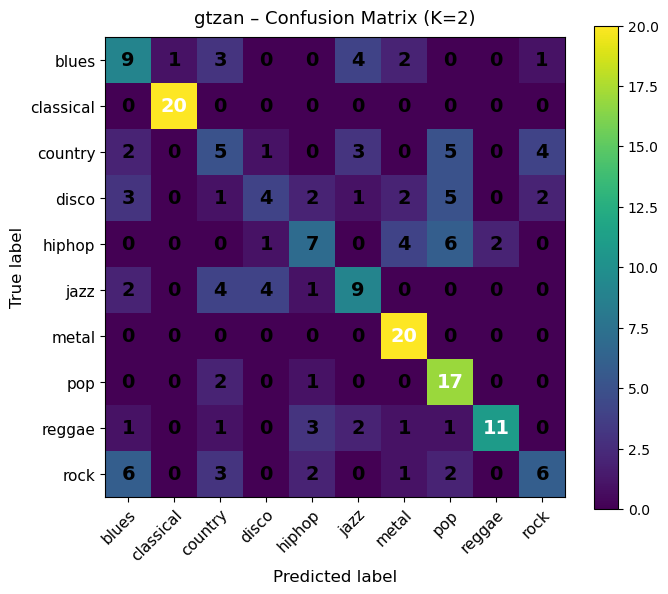


--- K = 8 ---


Evaluating K=8, true=blues: 20it [00:00, 42.33it/s]
Evaluating K=8, true=classical: 20it [00:00, 41.68it/s]
Evaluating K=8, true=country: 20it [00:00, 39.91it/s]
Evaluating K=8, true=disco: 20it [00:00, 40.53it/s]
Evaluating K=8, true=hiphop: 20it [00:00, 40.03it/s]
Evaluating K=8, true=jazz: 20it [00:00, 43.34it/s]
Evaluating K=8, true=metal: 20it [00:00, 42.80it/s]
Evaluating K=8, true=pop: 20it [00:00, 41.89it/s]
Evaluating K=8, true=reggae: 20it [00:00, 41.95it/s]
Evaluating K=8, true=rock: 20it [00:00, 41.86it/s]


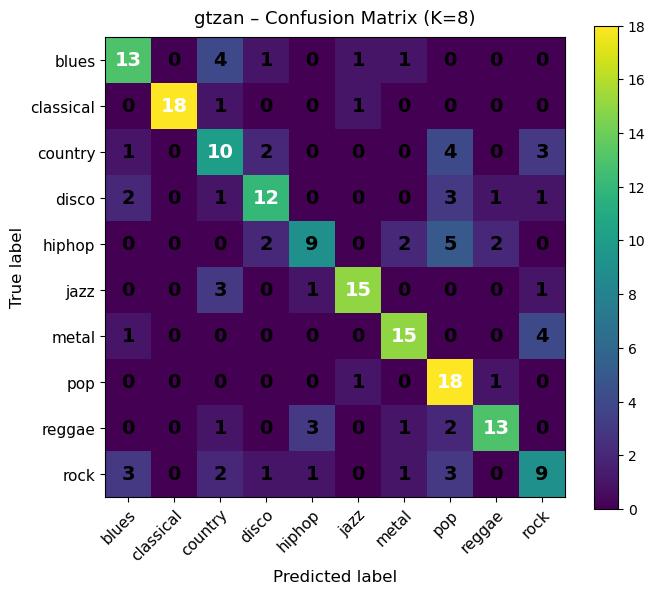


--- K = 16 ---


Evaluating K=16, true=blues: 20it [00:00, 31.01it/s]
Evaluating K=16, true=classical: 20it [00:00, 31.54it/s]
Evaluating K=16, true=country: 20it [00:00, 27.86it/s]
Evaluating K=16, true=disco: 20it [00:00, 26.30it/s]
Evaluating K=16, true=hiphop: 20it [00:00, 27.85it/s]
Evaluating K=16, true=jazz: 20it [00:00, 30.69it/s]
Evaluating K=16, true=metal: 20it [00:00, 30.35it/s]
Evaluating K=16, true=pop: 20it [00:00, 29.34it/s]
Evaluating K=16, true=reggae: 20it [00:00, 29.56it/s]
Evaluating K=16, true=rock: 20it [00:00, 28.14it/s]


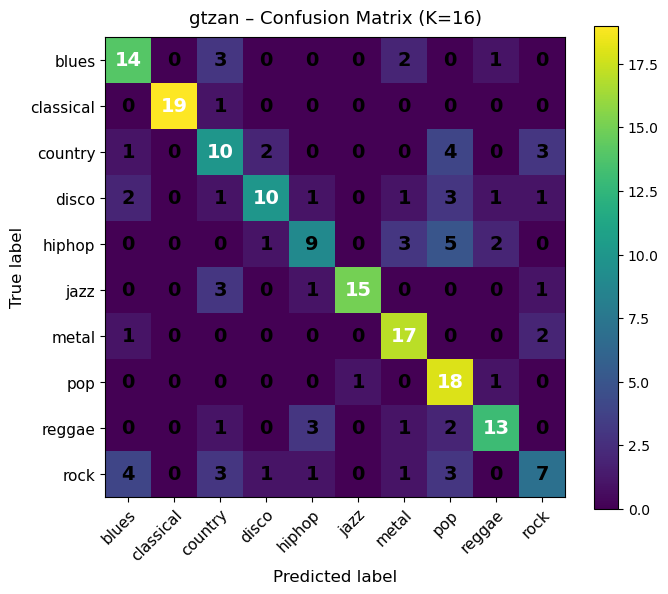


--- K = 64 ---


Evaluating K=64, true=blues: 20it [00:03,  5.15it/s]
Evaluating K=64, true=classical: 20it [00:03,  5.24it/s]
Evaluating K=64, true=country: 20it [00:03,  5.13it/s]
Evaluating K=64, true=disco: 20it [00:03,  5.34it/s]
Evaluating K=64, true=hiphop: 20it [00:03,  5.20it/s]
Evaluating K=64, true=jazz: 20it [00:03,  5.29it/s]
Evaluating K=64, true=metal: 20it [00:03,  5.24it/s]
Evaluating K=64, true=pop: 20it [00:03,  5.20it/s]
Evaluating K=64, true=reggae: 20it [00:03,  5.04it/s]
Evaluating K=64, true=rock: 20it [00:03,  5.12it/s]


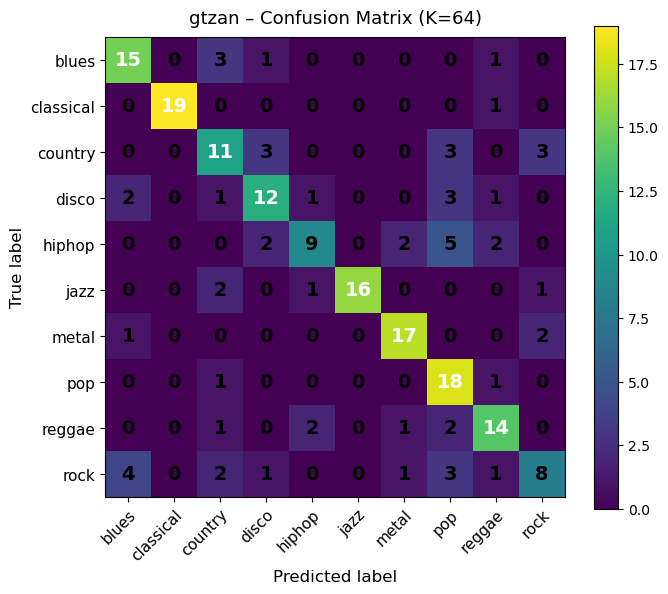

,K,Accuracy
0,2,0.540
1,8,0.660
2,16,0.660
3,64,0.695


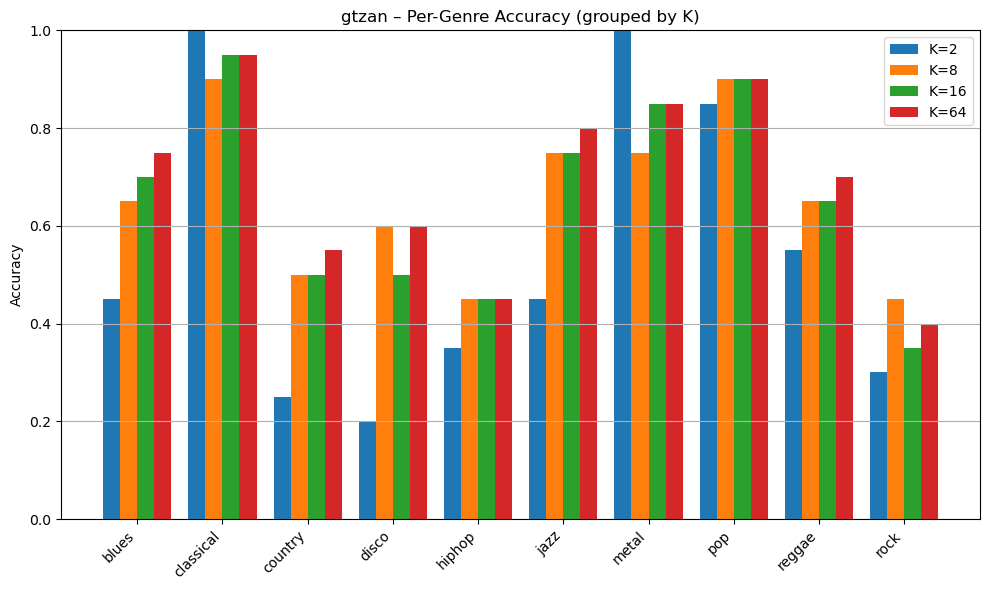

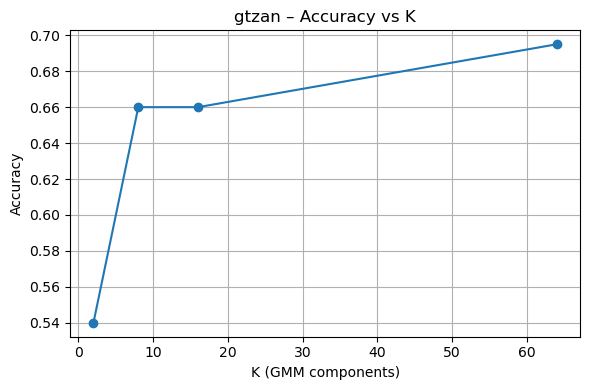

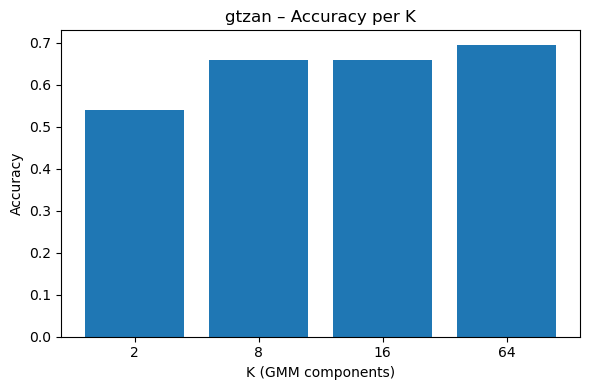

In [11]:
ALL_RESULTS = {}

for dataset_name in RUN_DATASETS:
    print(f"\n===== DATASET: {dataset_name} =====")
    DATA_DIR, FEAT_DIR, MODEL_DIR, RESULTS_DIR, GENRES = configure_dataset(dataset_name)

    if BUILD_FEATURES:
        build_features(DATA_DIR, FEAT_DIR, GENRES)

    dataset_results = {}

    for K in Ks:
        print(f"\n--- K = {K} ---")

        if TRAIN:
            train_gmm_system(K, FEAT_DIR, MODEL_DIR, GENRES)

        acc, cm, per_genre_acc = evaluate_system(K, FEAT_DIR, MODEL_DIR, GENRES)

        dataset_results[K] = {
            "accuracy": acc,
            "confusion_matrix": cm,
            "per_genre": per_genre_acc
        }

        plot_and_save_confusion_matrix(
            cm,
            GENRES,
            title=f"{dataset_name} – Confusion Matrix (K={K})",
            save_path=RESULTS_DIR / f"cm_K{K}.png"
        )

    df_overall, df_genre = save_accuracy_table(dataset_results, RESULTS_DIR)

    plot_grouped_per_genre_accuracy(
        dataset_results,
        GENRES,
        Ks,
        title=f"{dataset_name} – Per-Genre Accuracy (grouped by K)",
        save_path=RESULTS_DIR / "per_genre_grouped_by_K.png"
    )

    plot_accuracy_vs_K(
        df_overall,
        title=f"{dataset_name} – Accuracy vs K",
        save_path=RESULTS_DIR / "accuracy_vs_K.png"
    )

    plot_accuracy_bars(
        df_overall,
        title=f"{dataset_name} – Accuracy per K",
        save_path=RESULTS_DIR / "accuracy_per_K.png"
    )

    ALL_RESULTS[dataset_name] = dataset_results